In [1]:
import random
import numpy as np
from utils import *
from ploting import *

from IPython.core.display import HTML

# Custom CSS to change the background color of the progress bar
display(HTML("""
    <style>
        .progress .progress-bar {
            background-color: #f60 !important; /* Change the progress bar background color to black */
        }
    </style>
"""))

In [2]:
from uncertain.util.uncertaintreelearner import UncertainTreeLearner
from uncertain.owtree import ClassificationTreeLearner
from Orange.modelling.constant import ConstantLearner

post_hoc = UncertainTreeLearner(max_depth=None, min_samples_leaf=2, min_samples_split=4, sufficient_majority=0.90, post_hoc=True)
skl_tree = ClassificationTreeLearner(max_depth=None, min_samples_leaf=2, min_samples_split=4, sufficient_majority=0.90)
majority = ConstantLearner()

In [3]:
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA

def get_world_results(seed, features, errRange, NUMBER_OF_CLASSES, n_sample, rep): 
    results = []
    for err_range in errRange:
        print(f"  World Seed {seed}, errRange {err_range}")
        np.random.seed(seed)
        world = generate_world(seed, features, 
                            feature_bounds = (0, 1), 
                            endT = .2, endA = .3, max_depth = 4,
                            class_number = NUMBER_OF_CLASSES,
                            errRange = err_range, corr = 1)
        _, test_data = convert_np_to_orange(world, features)
        world = add_noise(world, errRange=0.05, mutation_rate=0.1)
        data, _ = convert_np_to_orange(world, features)
        for samples_per_class in n_sample:
            average_CA = np.array([0, 0, 0], dtype="float64")
            majority_class = CA(TestOnTestData(test_data, test_data=test_data, learners=[majority]))[0]
            for _ in range(rep):
                res = TestOnTestData(data=sample_data_orange(data, samples_per_class), test_data=test_data, learners=[skl_tree, post_hoc, uncertain_forest])
                average_CA += CA(res)
                # print(sample_data_orange(data, samples_per_class))
                # print(f"    samples_per_class: {samples_per_class}\n    Results:")
            average_CA = average_CA / rep * 100
            results.append([features, seed, err_range, samples_per_class, average_CA[0], average_CA[1], average_CA[2], majority_class])
            # print(f"  Results {samples_per_class}:\n      skl_tree          {round(average_CA[0], 2)}%\n      post_hoc          {round(average_CA[1], 2)}%\n      uncertain_forest  {round(average_CA[2], 2)}%")
    return results
            

In [3]:
def convert_pandas_to_orange(world, number_features):
    
    world["Class"] = world["Class"].astype(int)

    X = np.column_stack([world[f"Observed Value {i+1}"] for i in range(number_features)])
    Y = np.array(world["Class"])
    M = np.column_stack([world[f"Uncertainty {i+1}"] for i in range(number_features)])
    Xtv = np.column_stack([world[f"True Value {i+1}"] for i in range(number_features)])
    # Xrv = np.column_stack([world[f"Real Value {i+1}"] for i in range(number_features)])
    
    domain = Domain(
        attributes = [ContinuousVariable(f"Observed Value {i+1}") for i in range(number_features)],
        class_vars = DiscreteVariable("Class", values=[str(i) for i in range(max(Y+1))]),
        metas = [ContinuousVariable(f"Uncertainty {i+1}") for i in range(number_features)]
    )
    train_data = Table.from_numpy(domain, X=X, Y=Y, metas=M)
    
    domain = Domain(
        attributes = [ContinuousVariable(f"Observed Value {i+1}") for i in range(number_features)],
        class_vars = DiscreteVariable("Class", values=[str(i) for i in range(max(Y+1))])
    )
    test_data_tv = Table.from_numpy(domain, X=Xtv, Y=Y)  
      
    return train_data, test_data_tv

In [9]:
from utils import *
from ploting import *
import numpy as np
from concurrent.futures import as_completed, ProcessPoolExecutor, ThreadPoolExecutor
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA
from tqdm.notebook import tqdm


feature_bounds = (-1, 1)
n_feat = [2]
world_seed = 95
n_sample = [640, 1280, 10, 5]
rep = 100
errRange = list(np.arange(0, 21) / 10)
NUMBER_OF_CLASSES = 2
endT=.2
endArea = [.3]
max_depth = 4
learners = [skl_tree, post_hoc]
# correlation = [0.9, 0.8, 0.7, 0.6]

# Function to be executed in parallel
def run_experiment(features, world_gen_seed, err_range, n_sample, learners, endA = .2, correlation = 1):
    np.random.seed(world_gen_seed)
    world = generate_world_pandas(world_seed=world_gen_seed, data_seed=1, features=2,
                        no_samples = 10**4,
                        feature_bounds=feature_bounds, 
                        endArea=endA, max_depth=max_depth,
                        class_number=NUMBER_OF_CLASSES,
                        errRange=err_range, corr=correlation)#,
                        # mutation_rate = 0.05, errRange_real_world = 0.1, corr_real_world = 0.8)
    
    train_data, test_data = convert_pandas_to_orange(world, features)
    
    results = []
    majority_class = CA(TestOnTestData(test_data, test_data=test_data, learners=[majority]))[0]
    for samples_per_class in n_sample:
        for _ in range(rep):
            data = sample_data_orange(train_data, samples_per_class)
            res_tv = TestOnTestData(data=data, 
                                test_data=test_data, 
                                learners=learners)
            results.append([features, err_range, samples_per_class] + [val for val in CA(res_tv)] + [majority_class])                    
    return results

# Main execution block
results = []

# break
feat_PB = tqdm(total=1*len(errRange))
# for corr in correlation:
for endA in endArea:
    for features in n_feat:
        feat_PB.set_description(desc=f"{features} Feat fuzzy")
        feat_PB.reset()
        with ProcessPoolExecutor() as executor:
            futures = []
            world_gen_seed = world_seed
            for err_range in errRange:
                futures.append(executor.submit(run_experiment, features, world_gen_seed, err_range, n_sample, learners, endA))

            for future in as_completed(futures):
                # tv = future.result()
                # results_tv += future.result()
                results += future.result()
                feat_PB.update()

        df = pd.DataFrame(results, columns=["Features", "errRange", "n_samples", "skl", "post_hoc", "majority"])
        df.to_csv(f"tested_world{world_seed}.csv", index=False)
        results = []

# Process results as needed


  0%|          | 0/21 [00:00<?, ?it/s]

In [7]:
generate_world_pandas(world_seed=95, data_seed=1, features=2, 
                        feature_bounds=(-1, 1), 
                        endArea=.3, max_depth=4,
                        class_number=2,
                        errRange=0.1, corr=1)

,Class,True Value 1,True Value 2,Observed Value 1,Uncertainty 1,Error 1,Observed Value 2,Uncertainty 2,Error 2
0,0.0,-0.033407,0.527549,-0.050002,0.016596,-0.016596,0.588710,0.061160,0.061160
1,0.0,-0.226085,-0.101018,-0.182020,0.044065,0.044065,-0.092700,0.008317,0.008317
2,1.0,0.433624,-0.812281,0.333647,0.099977,-0.099977,-0.736503,0.075777,0.075777
3,0.0,-0.039794,-0.134466,-0.079328,0.039533,-0.039533,-0.044959,0.089507,0.089507
4,1.0,0.051129,-0.109226,-0.019519,0.070649,-0.070649,-0.042668,0.066558,0.066558
...,...,...,...,...,...,...,...,...,...
9995,1.0,-0.704463,-0.760905,-0.665530,0.038933,0.038933,-0.727910,0.032995,0.032995
9996,1.0,0.476662,-0.416252,0.435908,0.040754,-0.040754,-0.461970,0.045717,-0.045717
9997,0.0,0.644751,0.378928,0.556658,0.088093,-0.088093,0.363819,0.015108,-0.015108
9998,1.0,-0.715869,0.785955,-0.794260,0.078391,-0.078391,0.880000,0.094045,0.094045


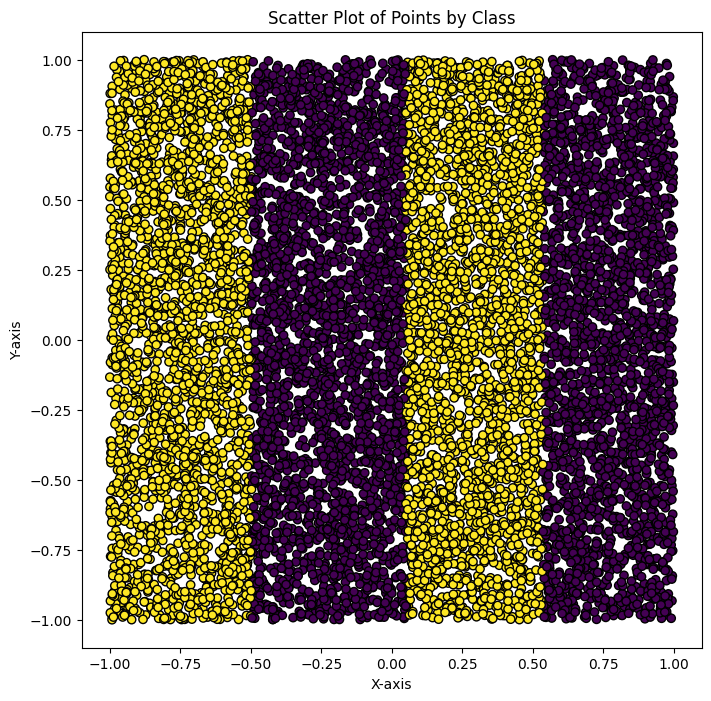

In [5]:
draw_world_from_seed(95,2,2,feature_bounds=(-1, 1))